<a href="https://colab.research.google.com/github/TheTarr/hw1/blob/zjy_colab/ntu_cv_project1_zjy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#读取图像文件并可视化


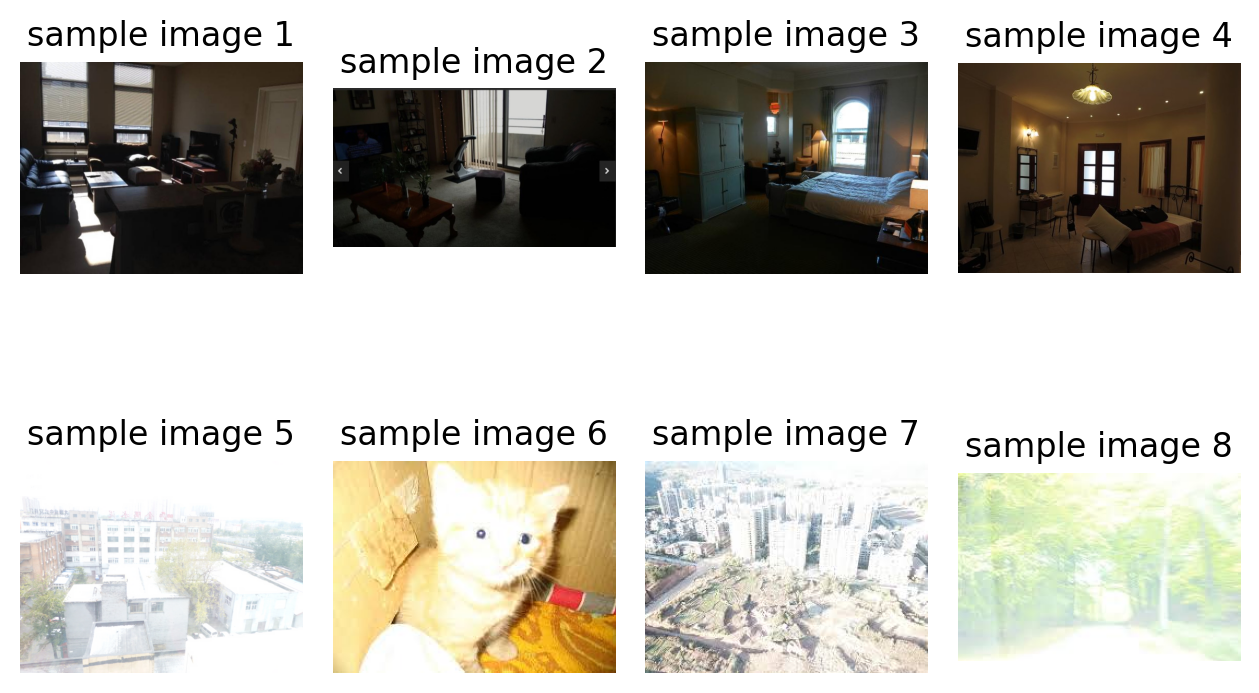

In [3]:
import cv2
import os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# path
dir_path = '/content/drive/MyDrive/Colab Notebooks/computer vision/project1/sample images'

# get all picture from that path
files = [os.path.join(dir_path, file) for file in os.listdir(dir_path)]
imgs = []

for file in files:
  imgs.append(cv2.imread(file))

plt.figure(dpi=200)
for i,img in enumerate(imgs):
  ax = plt.subplot(2,4,i+1)
  plt.axis('off')
  ax.set_title(f'sample image {i+1}')
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

# 将RGB图像转换为灰度图，计算直方图，并可视化


###灰度图转换

In [4]:
# convert RGB image to Gray image
def rgb2gray(img_loc):
  img = cv2.imread(img_loc)
  g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return g_img

g_imgs = []
for file in files:
  g_imgs.append(rgb2gray(file))

###计算直方图

In [5]:
# calculate the histogram data of the image ()
def cal_hist(img):
  pixel_level=np.array(img.tolist()).reshape(-1)
  return pixel_level

hists = []
for g_img in g_imgs:
  hists.append(cal_hist(g_img))

###可视化

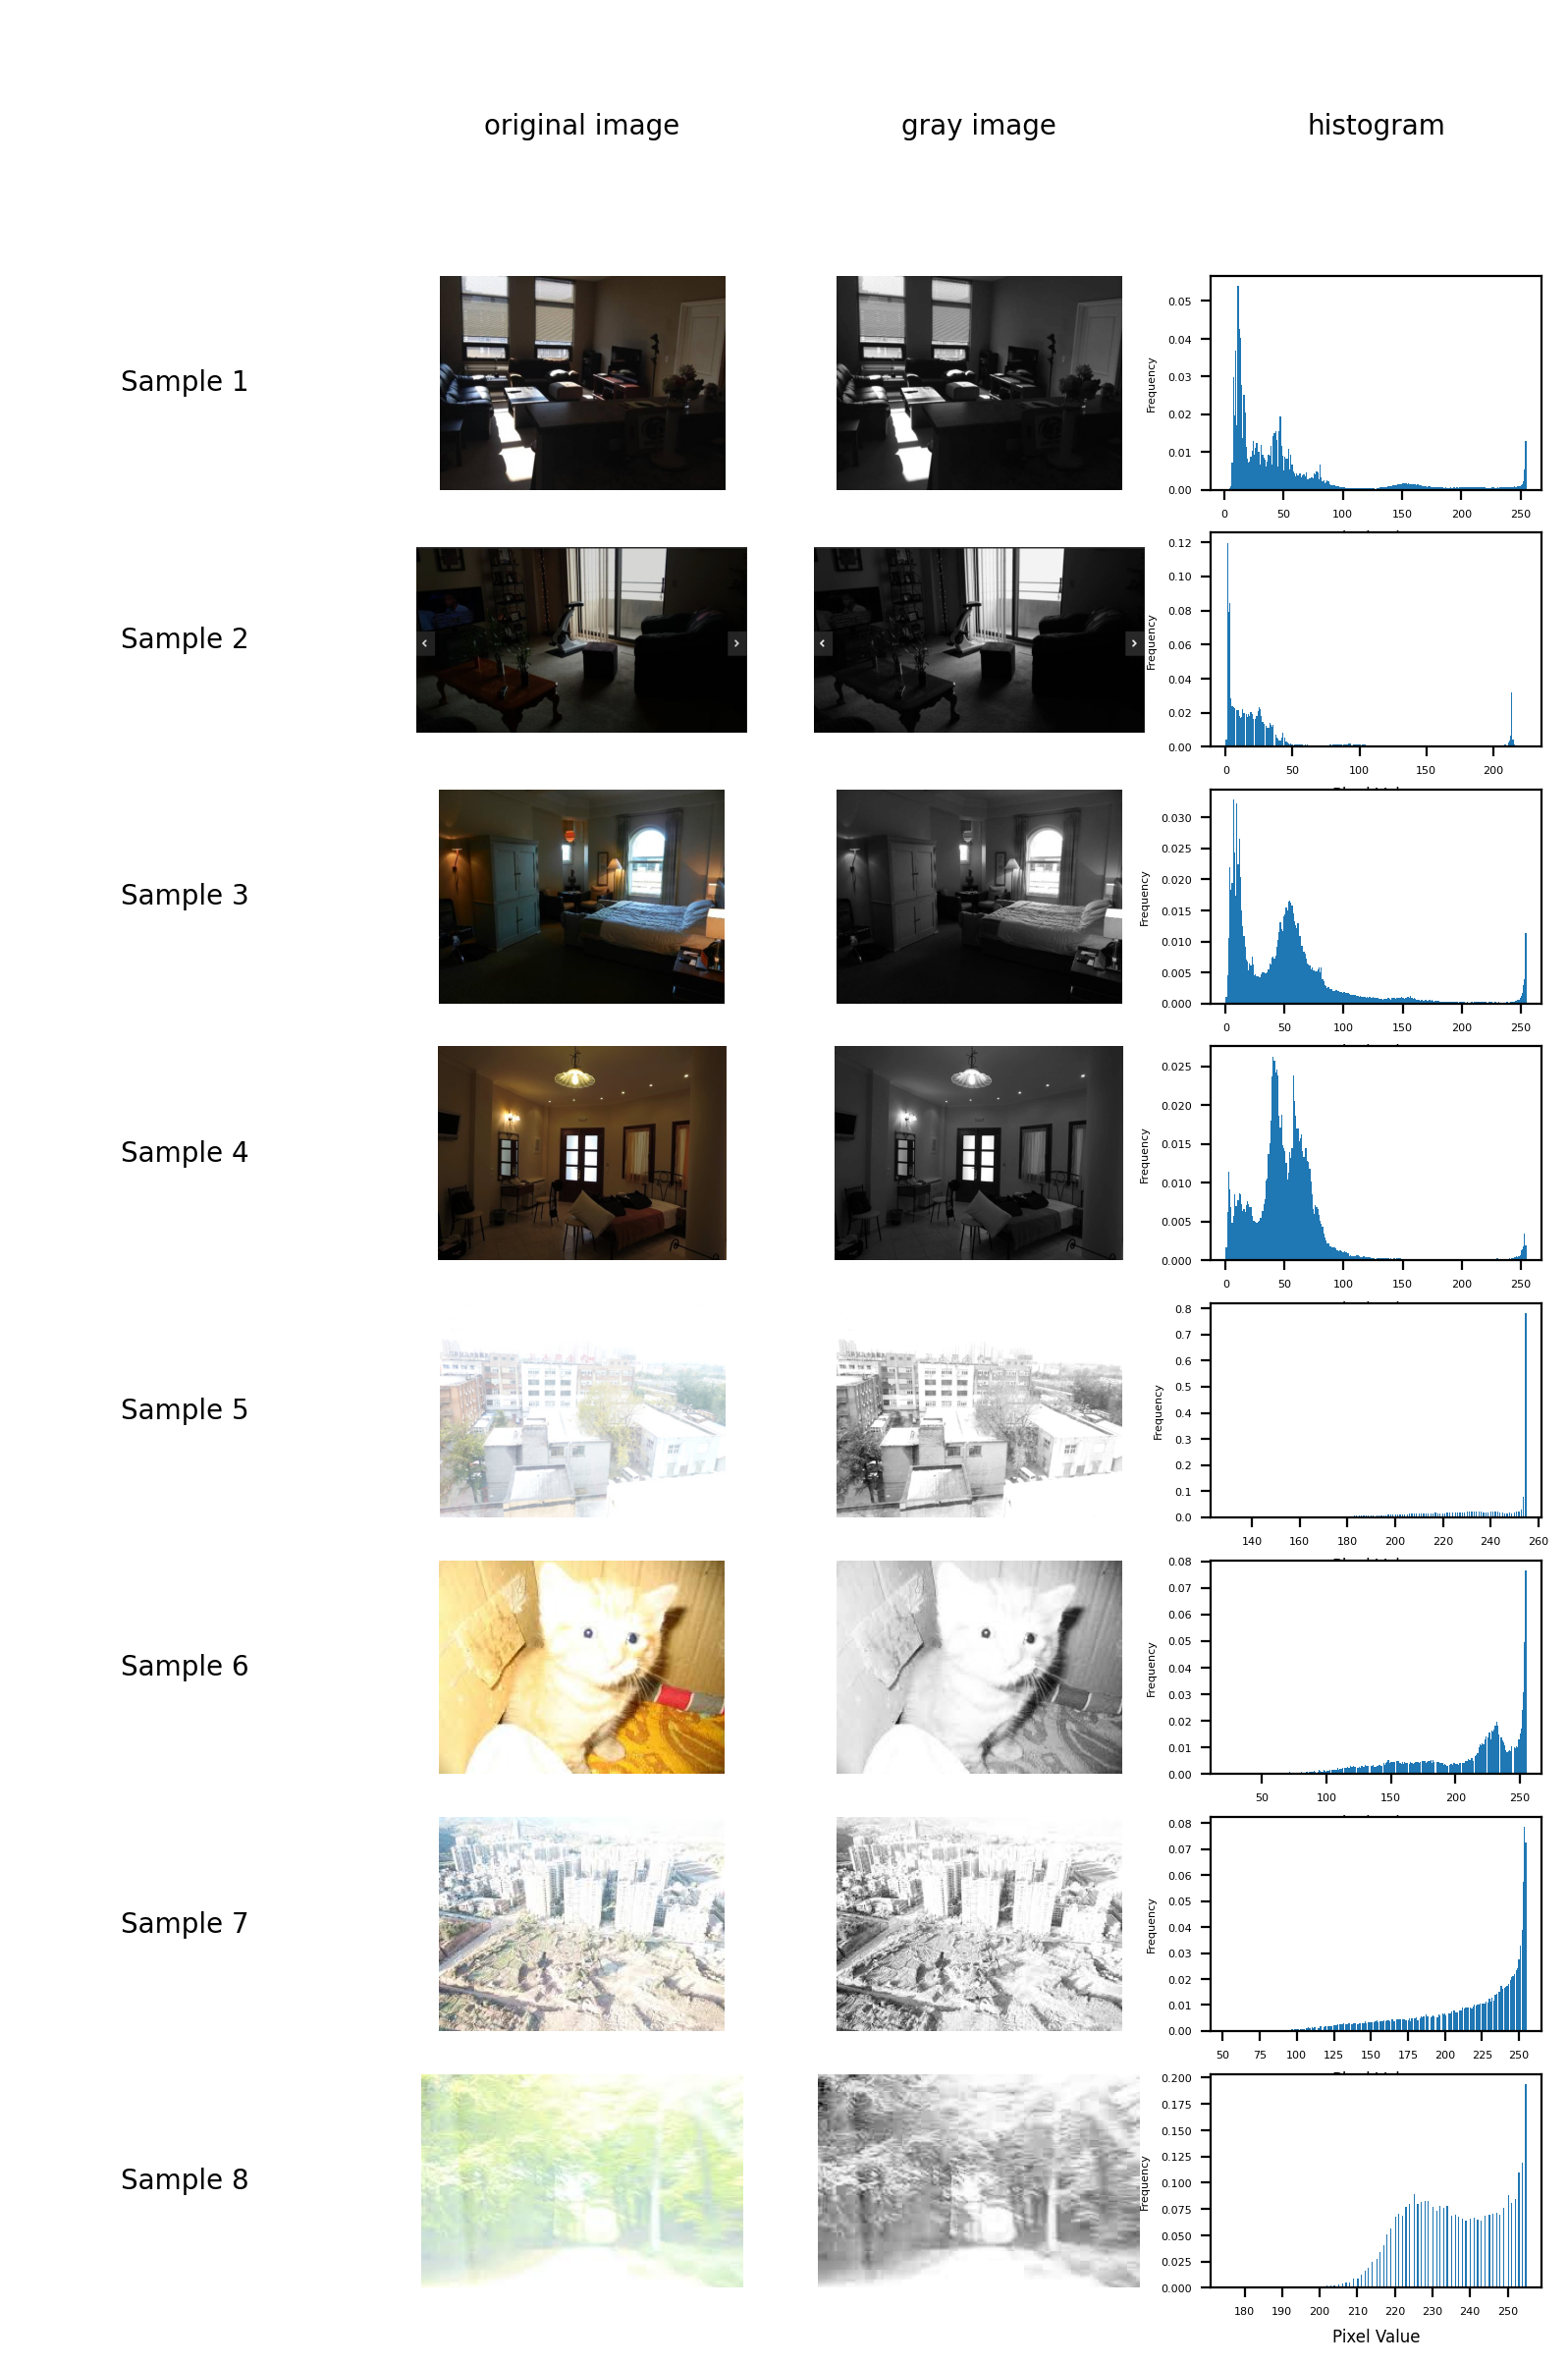

In [6]:
fig, axes = plt.subplots(nrows=9, ncols=4, dpi=200, figsize=(10, 15))

axes[0,0].set_axis_off()
for i in range(len(imgs)):
  axes[i+1,0].text(0.5, 0.5, f'Sample {i+1}', fontsize=10, ha='center', va='center')
  axes[i+1,0].set_axis_off()

col_name = ['original image','gray image','histogram']
for i, name in enumerate(col_name):
  axes[0,i+1].text(0.5, 0.5, name, fontsize=10, ha='center', va='center')
  axes[0,i+1].set_axis_off()

for i, (img, g_img, hist) in enumerate(zip(imgs,g_imgs,hists)):
  i = i+1
  axes[i,1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  axes[i,1].set_axis_off()
  axes[i,2].imshow(g_img,cmap='gray')
  axes[i,2].set_axis_off()
  axes[i,3].hist(hist, bins=256, density=True)
  axes[i,3].set_xlabel('Pixel Value', fontsize=6)
  axes[i,3].set_ylabel('Frequency', fontsize=4)
  axes[i,3].tick_params(axis='x', labelsize=4)
  axes[i,3].tick_params(axis='y', labelsize=4)

#plt.subplots_adjust(wspace=0.02, hspace=0.5)  # 调整水平和垂直间距
#plt.tight_layout()
plt.show()

#实现HE算法，对比处理结果


HE算法:


1.   计算出每个bin有多少个pixel
2.   计算出小于等于k强度的pixel数量
3.   对于每个k强度的像素集合,可以填充多少个bin
4.   计算k的映射值



In [14]:
def HE(channel, L):
    # initialize
    gray_count = [0] * 256
    p_count = [0] * 256
    # get image shape
    height,width = channel.shape
    # count how many pixels in each grayscale value
    channel = np.array(channel, dtype=np.uint8)
    for i in range(height):
        for j in range(width):
          gray_count[channel[i][j]] += 1
    #print(gray_count)
    # sum all pixels and map to 255
    for i in range(len(gray_count)):
        if i == 0:
            p_count[i] = (gray_count[i] / (height * width)) * 255
        else:
            p_count[i] = (gray_count[i] / (height * width)) * 255 + p_count[i-1]
    # get f(x) for each layer
    layer_range = 256 // L
    for l in range(L):
        for i in range(l * layer_range, (l + 1) * layer_range):
            k = 0
            while p_count[i] - k > 0:
                k += 1
            diff = k - p_count[i]
            if diff <= 0.5:
                p_count[i] = k
            else:
                p_count[i] = k - 1
    #print(p_count)
    # do y = f(x) for each layer
    for i in range(height):
        for j in range(width):
            channel[i][j] = p_count[channel[i][j]]
    return channel

在RGB三个维度分别运行HE算法,之后合并三个维度

In [15]:
con_imgs = []
con_hists = []

#先将图片分成RGB三维，之后分别在三维运行HE算法，之后再进行合并
def run_HE_channels(img, L):
  B,G,R = cv2.split(img)
  B_ = HE(B, L)
  G_ = HE(G, L)
  R_ = HE(R, L)
  return cv2.merge([B_,G_,R_])

for img in tqdm(imgs, desc="Processing"):
  con_imgs.append(run_HE_channels(img, 64)) # L equals to 8, means that there are 8 bins in the histogram

for con_img in tqdm(con_imgs, desc="Processing"):
  g_con_img = cv2.cvtColor(con_img, cv2.COLOR_BGR2GRAY)
  con_hists.append(cal_hist(g_con_img))




Processing: 100%|██████████| 8/8 [00:00<00:00, 45.62it/s]


###可视化结果对比

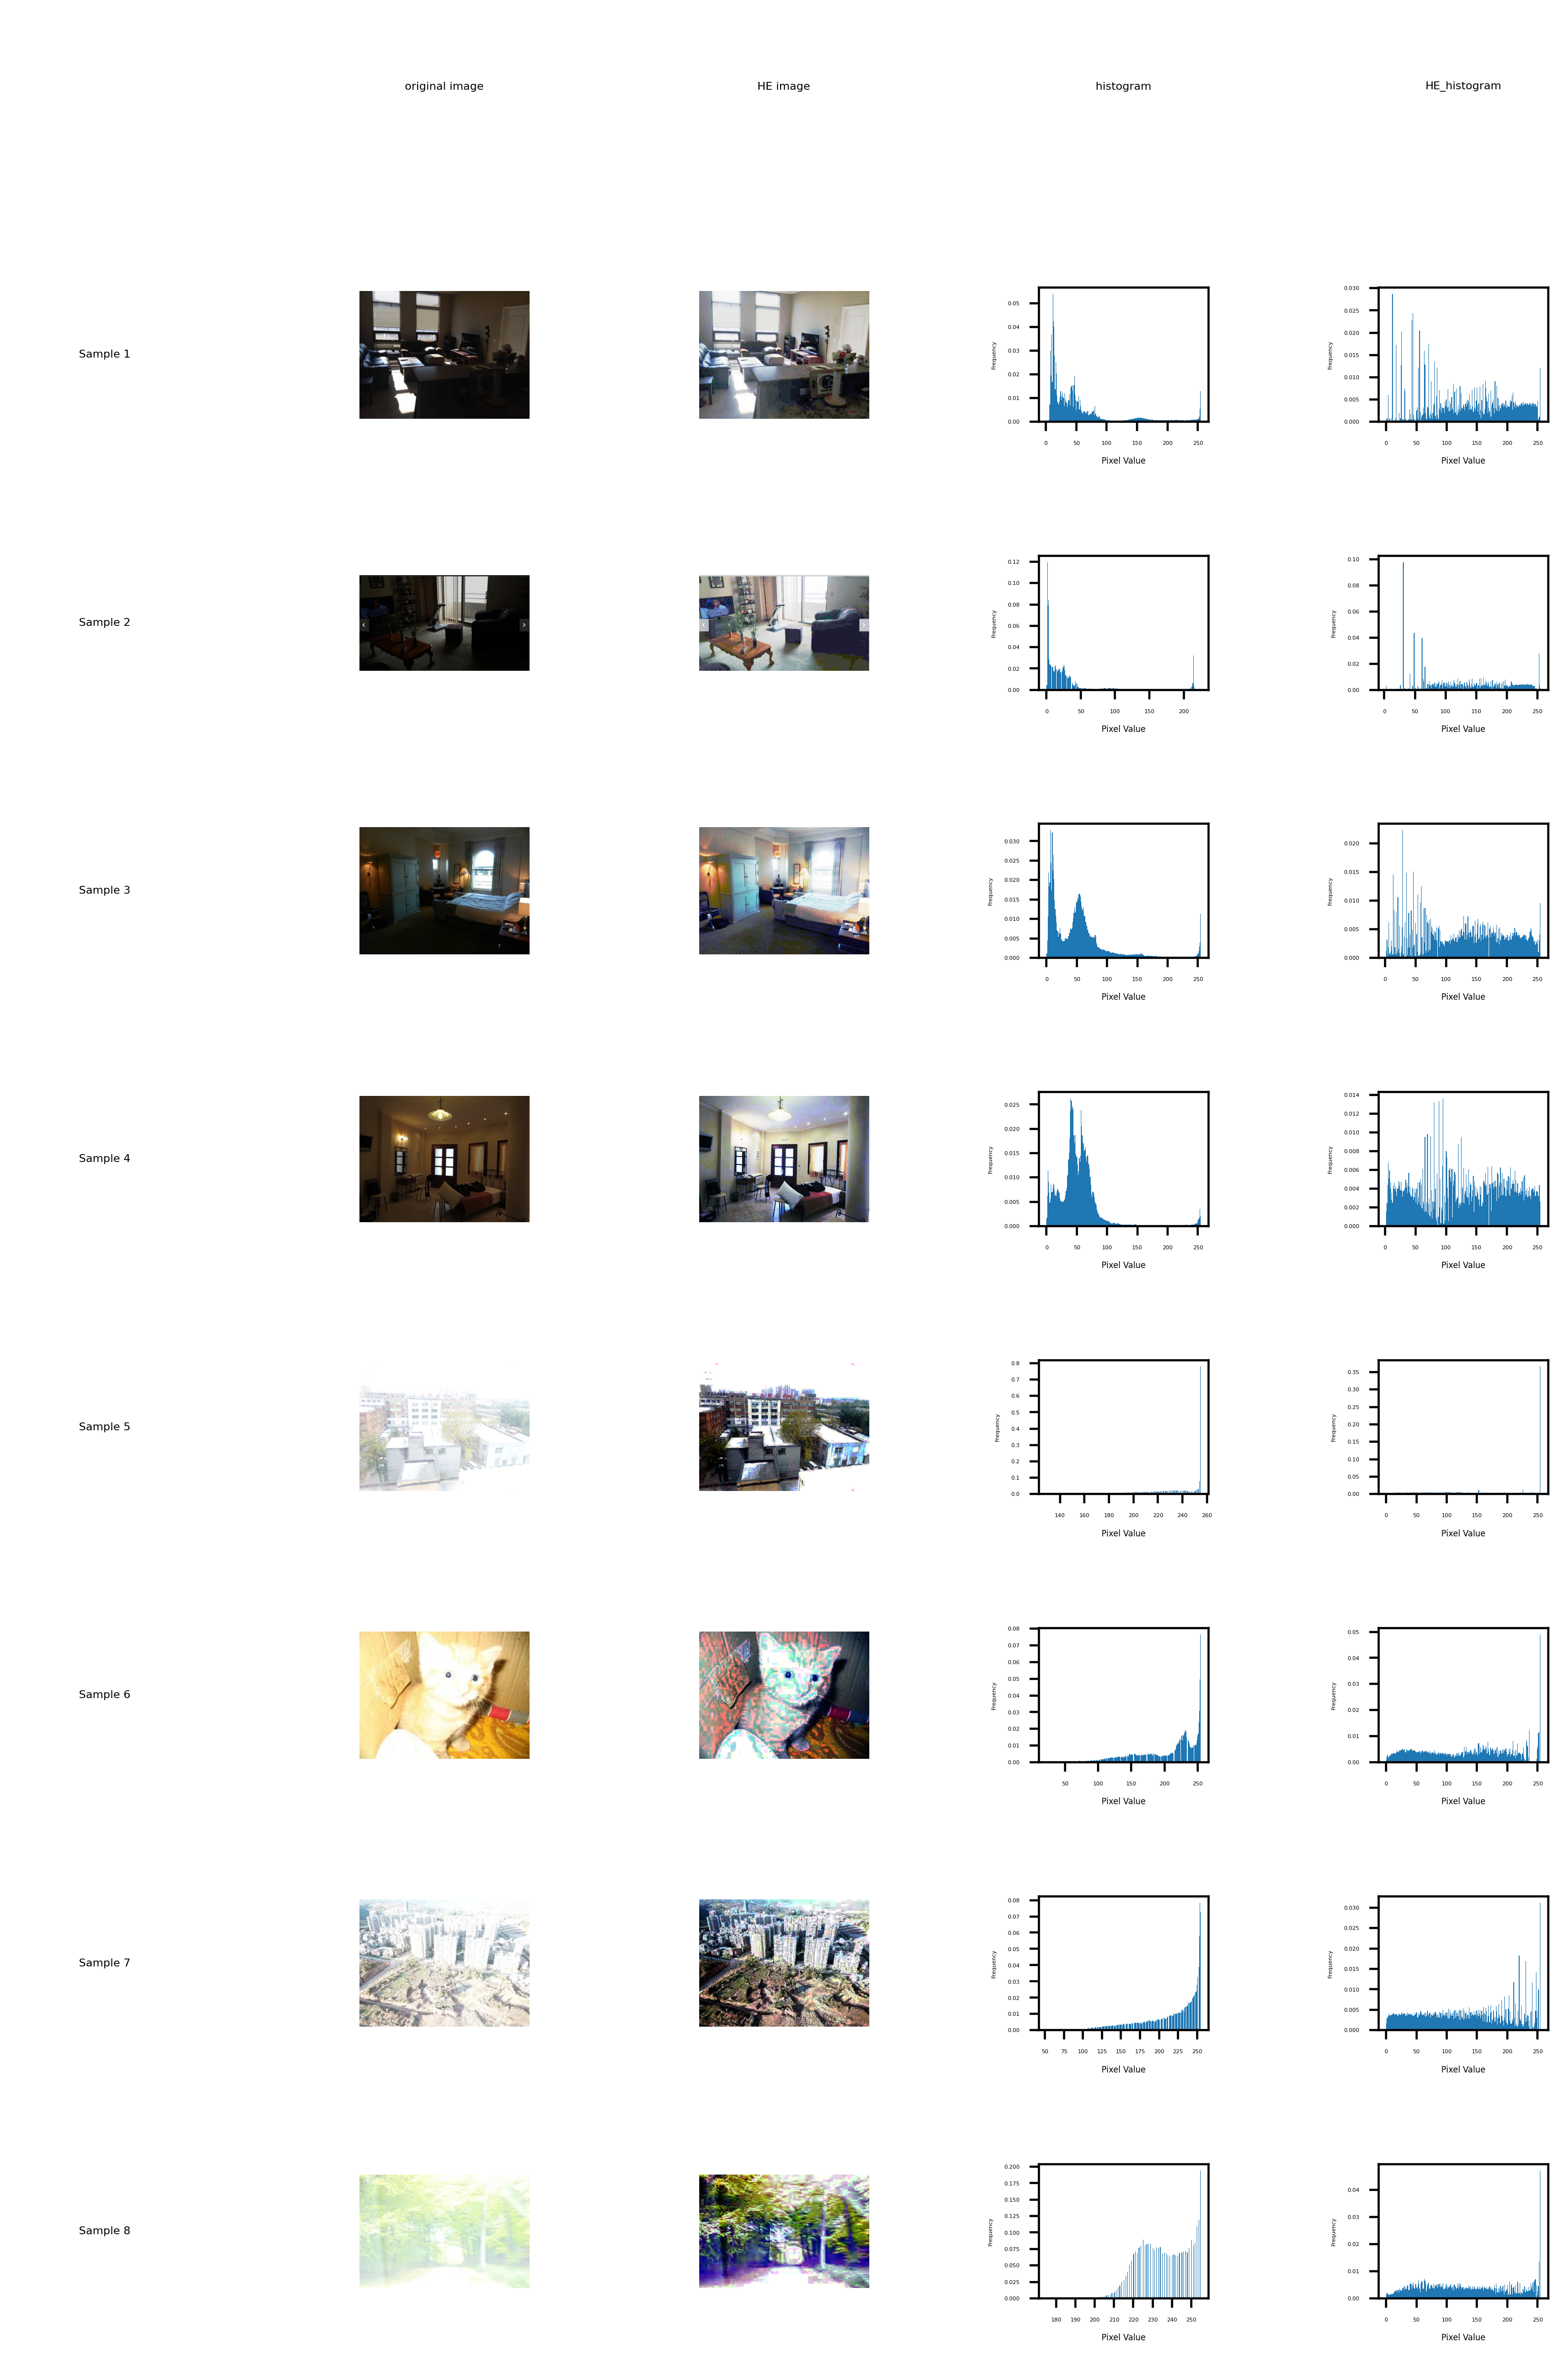

In [17]:
fig, axes = plt.subplots(nrows=9, ncols=5, dpi=400, figsize=(10, 15))

axes[0,0].set_axis_off()
for i in range(len(imgs)):
  axes[i+1,0].text(0.5, 0.5, f'Sample {i+1}', fontsize=4, ha='center', va='center')
  axes[i+1,0].set_axis_off()

col_name = ['original image','HE image','histogram','HE_histogram']
for i, name in enumerate(col_name):
  axes[0,i+1].text(0.5, 0.5, name, fontsize=4, ha='center', va='center')
  axes[0,i+1].set_axis_off()

for i, (img, con_img, hist, con_hist) in enumerate(zip(imgs,con_imgs,hists,con_hists)):
  i = i+1
  axes[i,1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  axes[i,1].set_axis_off()
  axes[i,2].imshow(cv2.cvtColor(con_img, cv2.COLOR_BGR2RGB))
  axes[i,2].set_axis_off()
  axes[i,3].hist(hist, bins=256, density=True)
  axes[i,3].set_xlabel('Pixel Value', fontsize=3)
  axes[i,3].set_ylabel('Frequency', fontsize=2)
  axes[i,3].tick_params(axis='x', labelsize=2)
  axes[i,3].tick_params(axis='y', labelsize=2)
  axes[i,4].hist(con_hist, bins=256, density=True)
  axes[i,4].set_xlabel('Pixel Value', fontsize=3)
  axes[i,4].set_ylabel('Frequency', fontsize=2)
  axes[i,4].tick_params(axis='x', labelsize=2)
  axes[i,4].tick_params(axis='y', labelsize=2)

plt.subplots_adjust(wspace=1, hspace=1)  # 调整水平和垂直间距
plt.show()

###放大后可以看出5图和6图表现不佳

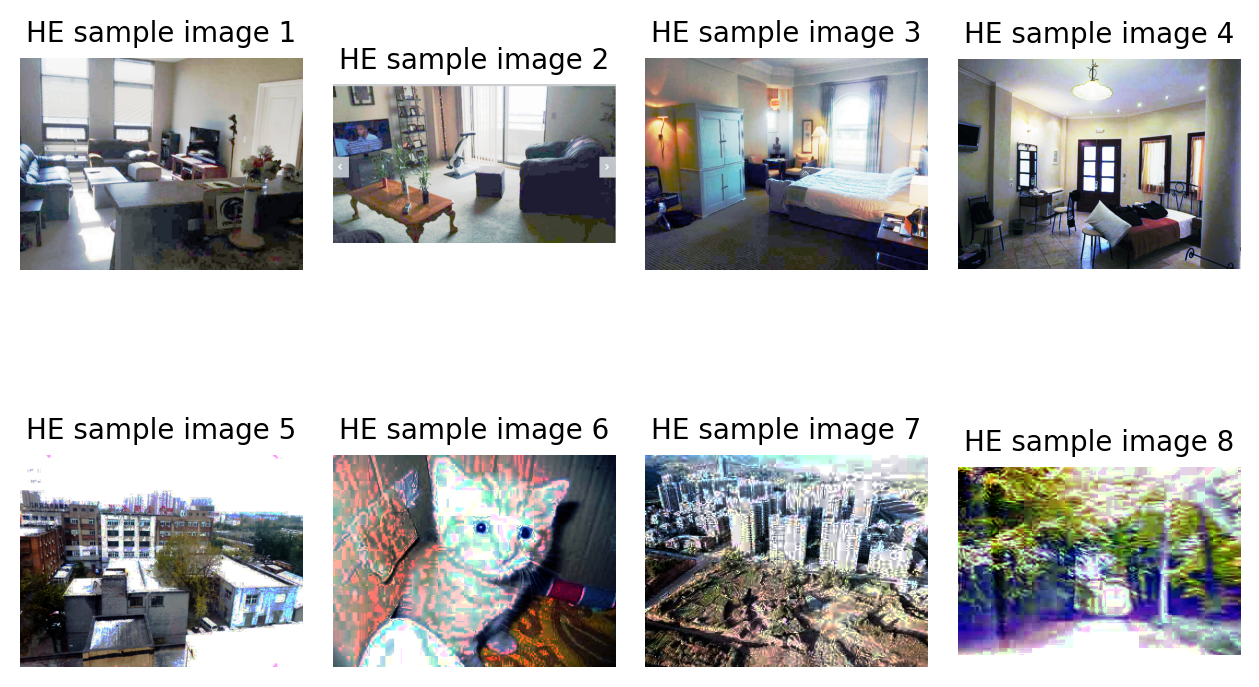

In [19]:
plt.figure(dpi=200)
for i,con_img in enumerate(con_imgs):
  ax = plt.subplot(2,4,i+1)
  plt.axis('off')
  ax.set_title(f'HE sample image {i+1}',fontsize=10)
  ax.imshow(cv2.cvtColor(con_img, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

#改进原算法（图5）

###尝试使用不同bin的数量

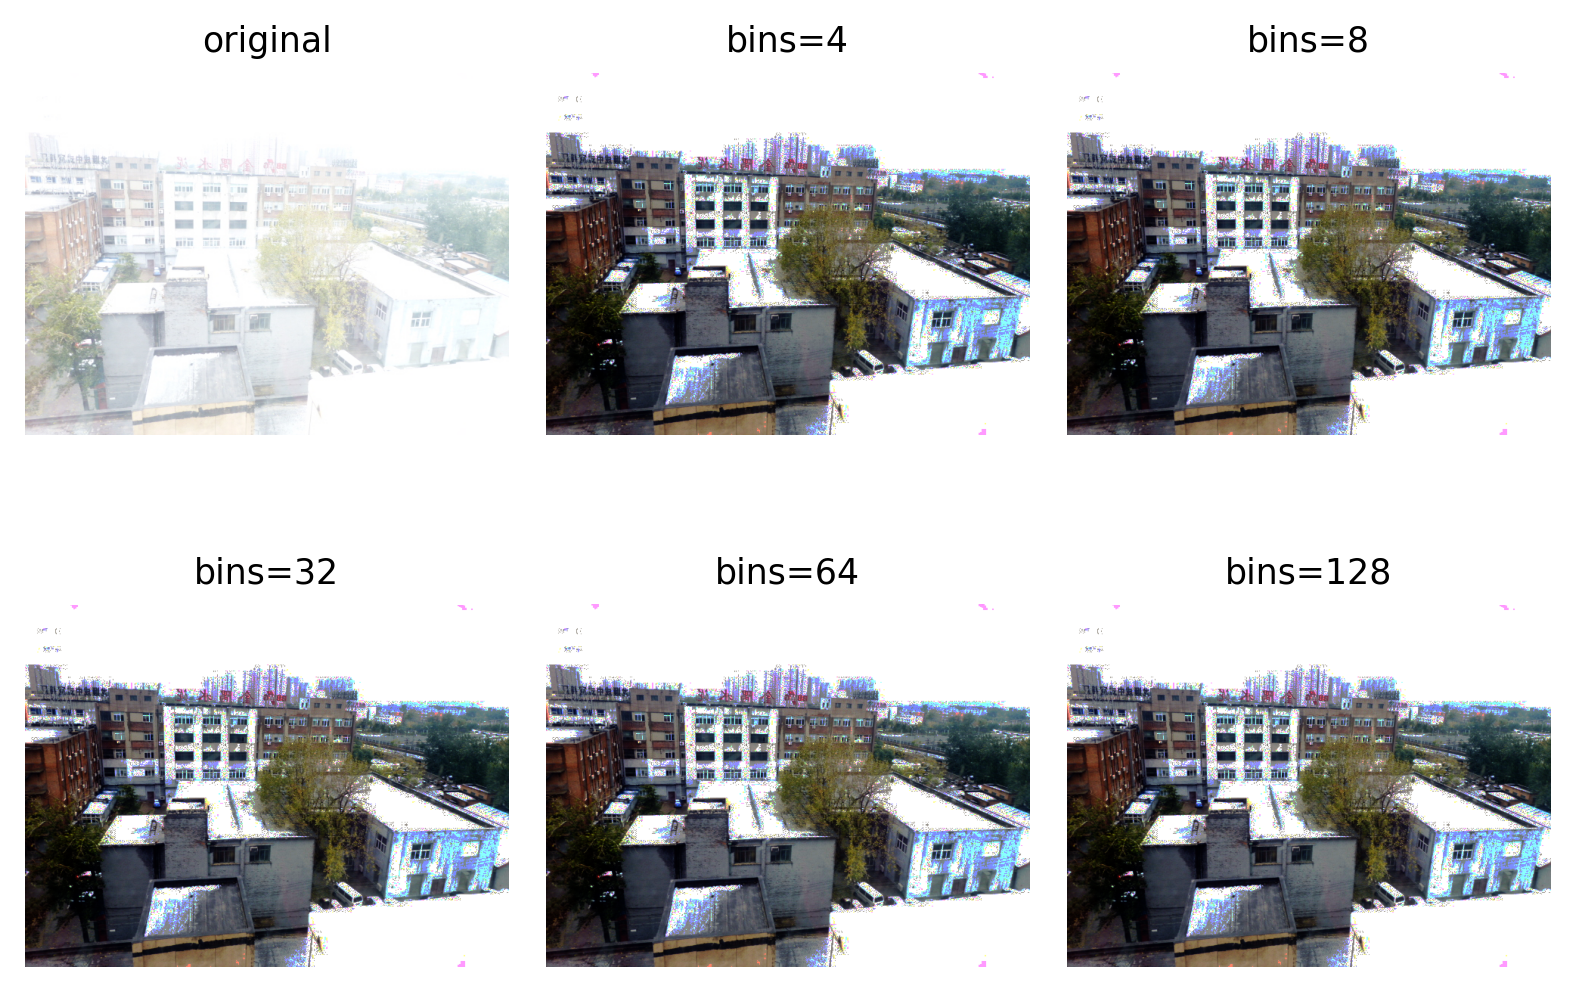

In [25]:
Layers = [4,8,32,64,128]
HE5 = []
for L in Layers:
  HE5.append(run_HE_channels(imgs[4], L)) # L equals to 8, means that there are 8 bins in the histogram

plt.figure(dpi=250)
plt.subplot(2, (len(HE5)+1)//2, 1)
plt.axis('off')
plt.imshow(cv2.cvtColor(imgs[4], cv2.COLOR_BGR2RGB))
plt.title('original',fontsize=10)
for i,f in enumerate(HE5):
  plt.subplot(2, (len(HE5)+1)//2, i+2)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
  plt.title(f'bins={Layers[i]}',fontsize=10)
plt.tight_layout()
plt.show()

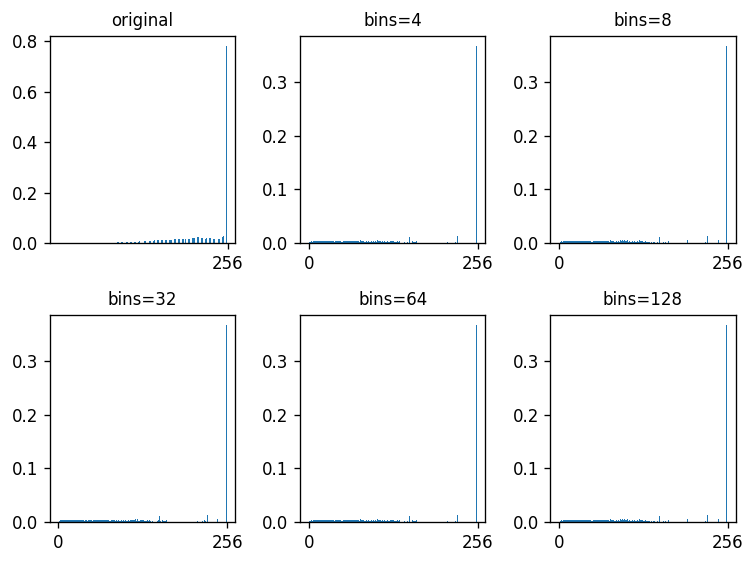

In [24]:
HE5_hists=[]
for f in HE5:
  HE5_hists.append(cal_hist(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)))

plt.figure(dpi=120)
plt.subplot(2, (len(HE5)+1)//2, 1)
plt.xticks([0,256])
plt.hist(hists[4],bins=256,density=True)
plt.title('original',fontsize=10)
for i,f in enumerate(HE5_hists):
  plt.subplot(2, (len(HE5)+1)//2, i+2)
  plt.xticks([0,256])
  plt.hist(f,bins=256,density=True)
  plt.title(f'bins={Layers[i]}',fontsize=10)
plt.tight_layout()
plt.show()

#改进原算法（图6）

###尝试使用不同bin的数量

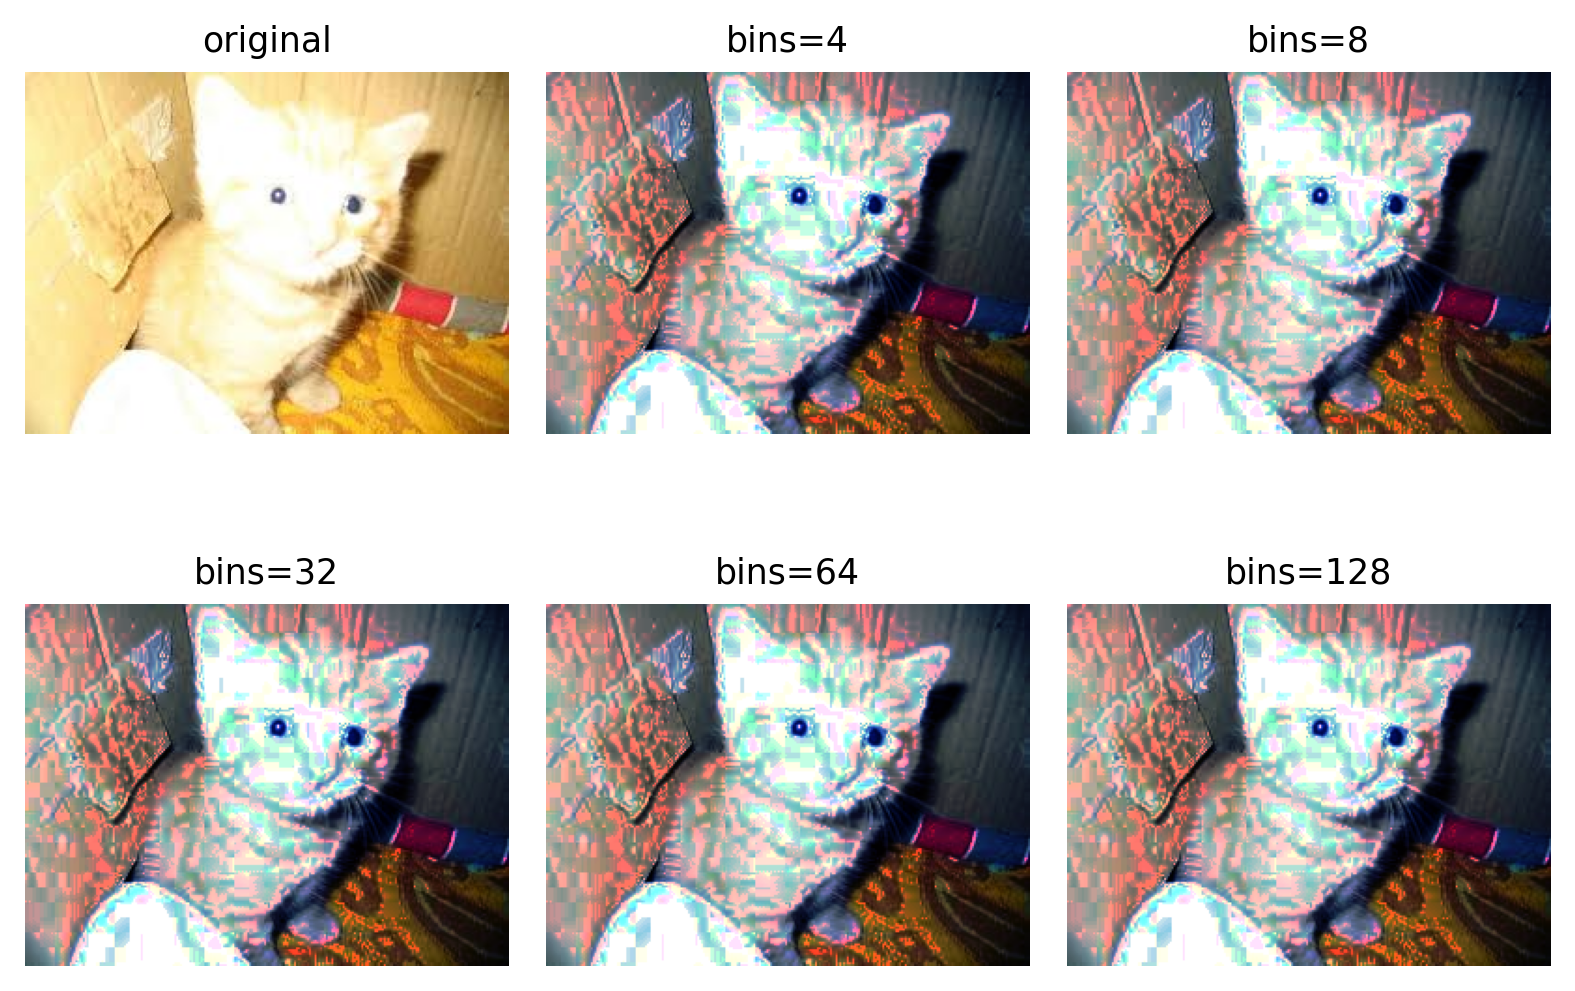

In [28]:
Layers = [4,8,32,64,128]
HE6 = []
for L in Layers:
  HE6.append(run_HE_channels(imgs[5], L)) # L equals to 8, means that there are 8 bins in the histogram

plt.figure(dpi=250)
plt.subplot(2, (len(HE6)+1)//2, 1)
plt.axis('off')
plt.imshow(cv2.cvtColor(imgs[5], cv2.COLOR_BGR2RGB))
plt.title('original',fontsize=10)
for i,f in enumerate(HE6):
  plt.subplot(2, (len(HE6)+1)//2, i+2)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
  plt.title(f'bins={Layers[i]}',fontsize=10)
plt.tight_layout()
plt.show()

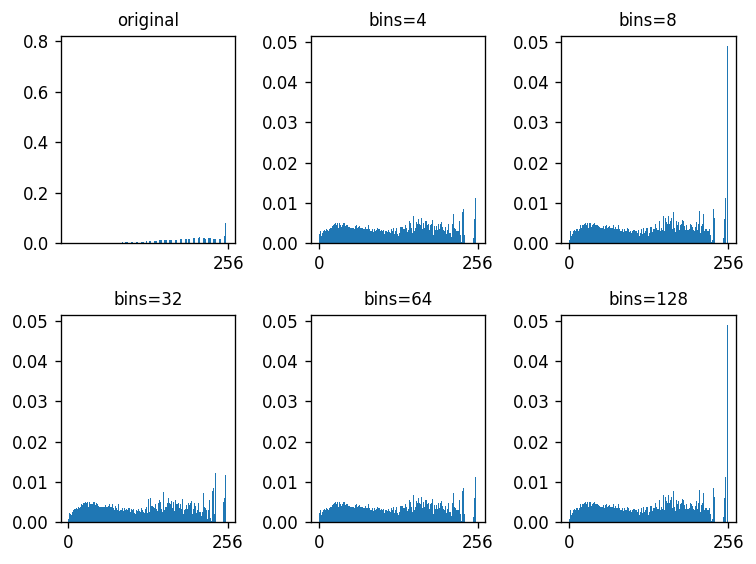

In [29]:
HE6_hists=[]
for f in HE6:
  HE6_hists.append(cal_hist(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)))

plt.figure(dpi=120)
plt.subplot(2, (len(HE6)+1)//2, 1)
plt.xticks([0,256])
plt.hist(hists[4],bins=256,density=True)
plt.title('original',fontsize=10)
for i,f in enumerate(HE6_hists):
  plt.subplot(2, (len(HE6)+1)//2, i+2)
  plt.xticks([0,256])
  plt.hist(f,bins=256,density=True)
  plt.title(f'bins={Layers[i]}',fontsize=10)
plt.tight_layout()
plt.show()